#Simulating Users

### Possible Topics
* Setup:
    * Me (data science type, lots of for loops, clever in python)
    * Them (devs, specs, dbs, not inference, tests if you are lucky)
    * testing is a place we can all communicating
* A/B Testing (notion vs truth)
    * Diagram of simple vs Bing
* Problem statement (it's one thing to to execute a plan, it's another to achieve robust/trustworthy exp)
* Design vs Execution vs Scorecard
    * Design can add complexity
    * Execution is not analysis
    * Scorecard is a "view" not the truth
    * Parallel views (what someone did versus what we logged)
* Execution to Scorecard phase:
    * Empirically has had problems
    * Many are just incorrect execution
    * Some are incorrect aggregation
    * Most were fixable with unit testing
* Scaling and testing:
    * Don't need actual experiments...we can simulate
* Simulation
    * Humans are suprisingly simple when it comes to log lines
    * Artifact of what we log to some extent
    * Can produce surprisingly accurate aggregate results
* Simple flow:
    1. Human visits
    2. Human has choice (often influenced by treatment...you hope)
    3. Human makes choice
    4. (Optional) Human repeats 2 and 3 additional times
    * Key point: Logs are *generated* by a process
* Abstract the process:
    1. Present a choice (probability distribution)
    2. Draw from that distribution
    3. Given the draw, present a second choice (another probability distribution, possibly different)
    4. Draw again
    5. Repeat
    * Simple process but it captures the essence of the experiment
    * The layering of draws and choice of distributions inject flexibility and complexity
* Example:
    * Simple click stream of an offer
    * Provides a way for the devs to interact with the logs in multiple ways
    * Easy to write tests for summary stats
* Find the "unknown" parameters
    * Simulated logs are noisy instaniations of your supplied parameters
    * In other words, you put a number into the function and it spit out a ton of hand wavey examples
    * Your task (well, the dev's task) is to recover that parameter (within reason)
    * This is the foundation of the unit test framework
* Example test:
    * CTR difference between two groups
    * How do I deal with "random" data in an assert?
    * `Almost Equal`?
* Dealing with random data:
    * Seed (although this will not enable robustness)
    * p-value (expensive since I need to test the function ~1000 times)
    * Comparisons (balance between the two...i.e. do I always manage to find the more true one)
    * I tend to land on the seed method when starting, migrate to p-value for robustness, and do comparisons when devs complain my tests take too long (doesn't happen that often)
* End to end test for a conversion
    * what do I need to test?
        * Log integrity (are there illegal values?) Instrumentation problems (THIS IS A HUGE DEAL)
        * Roll ups (you'd be surprised how broken this is)
        * Reverse A/A (you are doing this right?)
        * Comparisons (This is sort of the important part)
* What else can I do?
    * Simulate hypotheses
    * Be really brute force about sample size calculation
    * Practice scaling
    * How do bugs or problem "trickle down"

# Who Needs Users? Just Simulate Them!

**Chris Harland**

**Data Scientist**

**Context Relevant**

**@cdubhland**

### Me:
Not a production programmer...
### Them:
"Real" programmers
### Problem:
Experimentation platforms need both

I claim unit testing is a place we can all "agree"

# Who needs experimentation?

Well...we do

It is how we (as in humans) establish **causality**

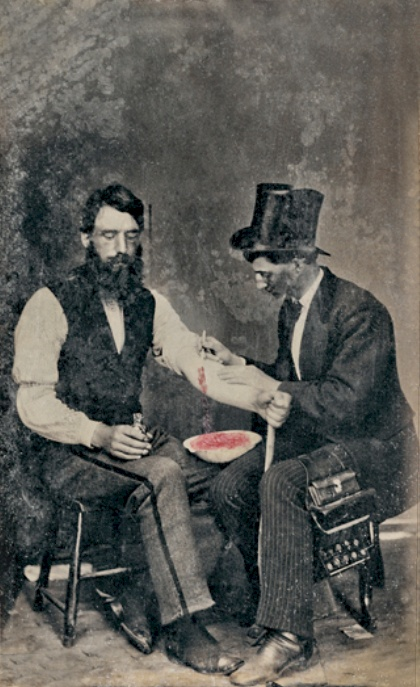

In [17]:
from IPython.display import Image
Image(filename='bloodletting.jpg', width = 300)

     The Burns Archive - Burns Archive via Newsweek, 2.4.2011

### A/B testing (a bit more complicated than you think...)

Executing the play book **is not** the full story

### A peek into my bias:

Experimentation is the story of three logs:
1. Treatment Assignment
2. Exp Platform
3. Product

Together these comprise the **execution** not the **analysis**

Reality : Logs :: Scientific Truth : Scorecard

Assume you have a platform (of some kind) and a product (of some kind)

Common stumbling blocks:
* Bucketing (random numbers are hard)
* Scorecarding (counting, aggregating, and stats)

It's possible to avoid some "pitfalls"

Critical to know your platform works because users are wacky

### What might a unit test look like?

In [18]:
# code mock up
def test_bucket_split(self):
    # Ensure that user bucketing created two equivalent groups
    for metric in self.important_metrics:
        assert abs(self.group_a[metric] - self.group_b[metric]) < self.tolerance

But where get these magical groups?

### How to know your black box works...

Make fake humans: Users are a collection of log lines

Skip the users and just get to the log lines

Anatomy of a log line:
    1. Human visits
    2. Human has choice (often influenced by treatment...you hope)
    3. Human makes choice
    4. (Optional) Human repeats 2 and 3 additional times

Logs are **generated** by a **process**

### Abstract the process

    1. Present a choice (probability distribution)
    2. Draw from that distribution (computer can do this)
    3. Given the draw, present a second choice (another probability distribution, possibly different)
    4. Draw again (hey a computer can do this to)
    5. Repeat (oh you bet a computer can do this)

Simple process but it captures the essence of the experiment

The layering of draws and choice of distributions inject flexibility and complexity

### Present a choice and then make it...

In [19]:
# if you like python 2.7 you can high five me @cdubhland
# if you are stunned by my lack of commitment to python 3
# you can send complaints to @joelgrus
from __future__ import division
from scipy import stats

def get_bernoulli_trial(p, n = 1):
    """ return a bernoulli trial of success or failure with probability p """
    return stats.bernoulli.rvs(p = p, size = n)

But all decisions aren't this simple =/

### Luckily math can bail us out

In [22]:
# We can make the probability of success a random variable
def get_beta_result(a,b, n = 1):
    """ takes a draw from beta(a,b) used to simulate random rates """
    return stats.beta.rvs(a,b, size = n)

# We can model a collection of user behaviors
def get_expon_result(mu, _lambda, n = 1):
    """ takes a draw from a exponential(mu, lambda) """
    return stats.expon.rvs(mu, _lambda, size = n)

# We can model the collective results of many choices
def get_exp_result(n,p, size = 1):
    """ return the outcome of n bernoulli trials with probability p """
    return stats.binom.rvs(n = n, p = p, size = size)

# Maybe the users visit at different frequencies
def gen_user_visit_freq(n_users = 100, _lambda = 2):
    """ return the total number of visits in a set time delta for the number of given users """
    return stats.poisson.rvs(mu = _lambda, size = n_users)